# ADMM applied in Neural Networks with Mnist dataset


In [1]:
# Preparation with environment for notebook
import random
import numpy as np
import matplotlib.pyplot as plt
from NeuralNetwork.data_utils import *

# Allow inline matplotlib figures appear in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Allow auto-reload of external modules 
%load_ext autoreload
%autoreload 2

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Preprocessing and Loading of dataset

In [2]:
# Load Mnist Data
mnistDir = "NeuralNetwork/MnistData"
X_train,Y_train,X_test,Y_test = getMnistData(mnistDir)

# Check the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', Y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', Y_test.shape

Training data shape:  (60000, 28, 28)
Training labels shape:  (60000,)
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


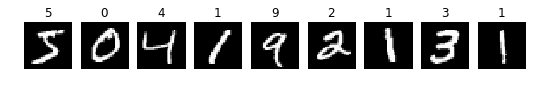

In [3]:
# Display part of the Mnist data
for xi in range(0,9):
    plt.subplot(1,10,xi+1)
    plt.imshow(X_train[xi])
    plt.axis('off')
    plt.title(Y_train[xi])

## Test NeuralNetwork


In [260]:
# Get MiniPatch
def getMiniPatch(X_train, Y_train, X_test, Y_test, trNum, teNum, transposed):
    # Subsample the data for more efficient code execution 
    trainNum = trNum
    mask = range(trainNum)
    Xtr = X_train[mask]
    Ytr = Y_train[mask]
    
    testNum = teNum
    mask = range(testNum)
    Xte = X_test[mask]
    Yte = Y_test[mask]
    
    # Reshape the image data into rows
    Xtr = np.reshape(Xtr, (Xtr.shape[0], -1))
    Xte = np.reshape(Xte, (Xte.shape[0], -1))
   
    # print Xtr.shape, Xte.shape
    if not transposed:
        return Xtr, Xtr, Ytr, Yte
    else:
        return Xtr.T, Xte.T, Ytr, Yte

from NeuralNetwork.neural_network import *
import time


case = [(50,50)]#(100,50),(500,50),(500,10),(5000,10),(5000,500),(20000,500),(20000, 2000)]
lam = [True, False]
for la in lam:
    print 'hasLambda = ',la
    for (trNum,teNum) in case:
        X_tr, X_te, Y_tr, Y_te = getMiniPatch(X_train, Y_train, X_train, Y_train, trNum, teNum, 1)
        print 'Xtr: ', X_tr.shape, 'Xte: ', X_te.shape, 'Ytr: ', Y_tr.shape, 'Yte: ', Y_te.shape
        
        # Initialize network
        hiddenLayer = [100, 150]
        classNum = 10 
        epsilon = 0.01
        network = NeuralNetwork(X_tr, Y_tr, classNum, hiddenLayer, epsilon)
        # Train
        weightConsWeight = 1
        activConsWeight = 10
        iterNum = 20
        hasLambda = la
        tic = time.time()
        """ lossType: hinge, msq, smx """
        network.train(weightConsWeight, activConsWeight, iterNum, hasLambda,'hinge')
        toc = time.time()
        print 'Total training time: %fs' % (toc - tic)

        # Predict
        Ypred = network.predict(X_te)
        print 'Prediction accuracy: %f' %np.mean(Ypred == Y_te)


hasLambda =  True
Xtr:  (784, 50) Xte:  (784, 50) Ytr:  (50,) Yte:  (50,)
Initializing a neural network with :  2  hidden layers, hidden layer dimension: [100, 150]
Total training time: 0.247338s
Prediction accuracy: 1.000000
hasLambda =  False
Xtr:  (784, 50) Xte:  (784, 50) Ytr:  (50,) Yte:  (50,)
Initializing a neural network with :  2  hidden layers, hidden layer dimension: [100, 150]
Total training time: 0.227664s
Prediction accuracy: 1.000000


## Test the neural network (Old)

In [163]:
from NeuralNetwork.admm import *
import time
def getStatistics(Xtr, Ytr, Xte, Yte, weightConsWeight, activConsWeight, iterNum, epsilon):
    # Initialize a 3-layer neural network with specified neuron dimension, 
    # the first dim is determined by the size of input dataset
    neuronDim = [0, 5, 3]
    network = NeuralNetwork(3, neuronDim)
    classNum = 10
    
    # Initialize weight matrix W of first layer 
    W = np.random.randn(Xtr.shape[1], classNum) * epsilon

    # Train
    tic = time.time()
    weight = network.train(W, Xtr, Ytr, weightConsWeight, activConsWeight, iterNum, epsilon)
    print weight[3].T
    toc = time.time()
    print 'Total training time: %fs' % (toc - tic)
    
    # Predict with the trained feature weight
    Ypred = network.predict(weight, Xte)
    print 'Prediction accuracy: %f' %np.mean(Ypred == Yte)
    
    
def miniPatchTest(trNum, teNum):
    # Subsample the data for more efficient code execution 
    trainNum = trNum
    mask = range(trainNum)
    Xtr = X_train[mask]
    Ytr = Y_train[mask]

    testNum = teNum
    mask = range(testNum)
    Xte = X_test[mask]
    Yte = Y_test[mask]
    
    # Reshape the image data into rows
    Xtr = np.reshape(Xtr, (Xtr.shape[0], -1))
    Xte = np.reshape(Xte, (Xte.shape[0], -1))
    
    # Specify weight coefficients of two regularization term, iteration of ADMM updates
    weightConsWeight = 1
    activConsWeight = 10
    iterNum = 10
    epsilon = 0.01
    getStatistics(Xtr, Ytr, Xtr, Ytr, weightConsWeight, activConsWeight, iterNum, epsilon)
    

test = {(30,13)}#{(100,10),(1000,100),(5000,100),(50000,1000)}
for (trNum,teNum) in test:
    print 'trainNum: %d  testNum %d' % (trNum, teNum)
    miniPatchTest(trNum,teNum)



trainNum: 30  testNum 13
Initializing a neural network:  3  layers; Neuron Dimension: [0, 5, 3]
[[ -3.58355295e-01  -7.07252094e-02  -1.84526334e-02]
 [  1.11735798e+01   7.16946902e+00   7.07876599e+00]
 [ -6.65550206e+00  -1.05971039e+01  -5.47400333e+00]
 [ -8.19467711e+00   1.07230900e+01  -1.96672479e+00]
 [ -1.79494429e+00  -1.36569110e-01   7.20542303e-01]
 [  4.35864729e-01  -4.24505170e-01   1.43525468e-01]
 [  8.83861686e-03   1.26276326e-01  -3.32266300e-01]
 [  6.59361665e+00  -1.18649246e+00  -1.03327290e+01]
 [ -6.79915259e-02  -1.14208440e-02   8.41061468e-03]
 [ -8.78063538e-01  -5.13080008e+00   1.42767387e+01]]
Total training time: 0.023799s
Prediction accuracy: 0.400000
